# Bước 1: Business Understanding

- Chưa có hệ thống Recommendation System
- Mục tiêu/ vấn đề: Xây dựng hệ thống đề xuất để hỗ trợ người dùng nhanh chóng chọn được nơi lưu trú phù hợp trên Agoda→ Hệ thống sẽ gồm hai mô hình gợi ý chính:
    + Content-based filtering
    + Collaborative filtering

# Bước 2: Data Understanding

In [53]:
import findspark
findspark.init()

In [54]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
SparkContext.setSystemProperty('spark.hadoop.dfs.client.use.datanode.hostname', 'true')

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize

from gensim import corpora, models, similarities
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql.window import Window

from pyspark.ml.feature import StringIndexer, OneHotEncoder

from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

import pandas as pd
from surprise import Reader, Dataset, SVD, SVDpp, NMF, SlopeOne, KNNBasic, KNNBaseline, KNNWithMeans, KNNWithZScore, CoClustering, BaselineOnly
from surprise.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder

ModuleNotFoundError: No module named 'pyspark'

In [56]:
sc = SparkContext()

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at C:\Users\CUONG\AppData\Local\Temp\ipykernel_9668\1542122174.py:1 

In [ ]:
spark=SparkSession(sc)

#### Đọc File hotel_info.csv

In [ ]:
data_info=pd.read_csv('hotel_info.csv')

### Xem thông tin

In [ ]:
data_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   num                       740 non-null    int64 
 1   Hotel_ID                  740 non-null    object
 2   Hotel_Name                740 non-null    object
 3   Hotel_Rank                740 non-null    object
 4   Hotel_Address             740 non-null    object
 5   Total_Score               740 non-null    object
 6   Location                  413 non-null    object
 7   Cleanliness               412 non-null    object
 8   Service                   373 non-null    object
 9   Facilities                370 non-null    object
 10  Value_for_money           410 non-null    object
 11  Comfort_and_room_quality  51 non-null     object
 12  comments_count            740 non-null    int64 
 13  Hotel_Description         739 non-null    object
dtypes: int64(2), object(12)
me

In [ ]:
# Xem số dòng và số cột
print('Dữ liệu có:',data_info.shape[0],'dòng và',data_info.shape[1],'cột')

Dữ liệu có: 740 dòng và 14 cột


In [57]:
# Xem tên cột
print(data_info.columns)

Index(['Hotel_ID', 'Hotel_Name', 'Hotel_Address', 'Hotel_Description',
       'Word_Count', 'Content', 'Content_wt'],
      dtype='object')


In [58]:
# Xem 5 dòng đầu
data_info.head()

,Hotel_ID,Hotel_Name,Hotel_Address,Hotel_Description,Word_Count,Content,Content_wt
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,"Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","Trần Phú, Lộc Thọ, Nha Trang, Việt Nam Khách s...",2702,Trần Phú Lộc Thọ Nha Trang Việt Nam Khách sạn ...,Trần_Phú_Lộc_Thọ Nha_Trang Việt_Nam Khách_sạn ...
1,1_2,ALPHA BIRD NHA TRANG,"Tue Tinh St, Loc Tho Ward, Nha Trang, Lộc Thọ...","Tue Tinh St, Loc Tho Ward, Nha Trang, Lộc Thọ...",2694,Tue Tinh St Loc Tho Ward Nha Trang Lộc Thọ Nha...,Tue Tinh_St Loc_Tho Ward Nha_Trang Lộc_Thọ Nha...
2,1_3,Khách sạn Aaron (Aaron Hotel),"Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam,","Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam,...",2467,Trần Quang Khải Lộc Thọ Nha Trang Việt Nam Khá...,Trần_Quang_Khải Lộc_Thọ Nha_Trang Việt_Nam Khá...
3,1_4,Panorama Star Beach Nha Trang,"Nguyen Thi Minh Khai, Lộc Thọ, Nha Trang, Việt...","Nguyen Thi Minh Khai, Lộc Thọ, Nha Trang, Việt...",2249,Nguyen Thi Minh Khai Lộc Thọ Nha Trang Việt Na...,Nguyen Thi_Minh Khai_Lộc_Thọ Nha_Trang Việt_Na...
4,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...,"B/ Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","B/ Trần Phú, Lộc Thọ, Nha Trang, Việt Nam Khác...",2580,B Trần Phú Lộc Thọ Nha Trang Việt Nam Khách sạ...,B Trần_Phú_Lộc_Thọ Nha_Trang Việt_Nam Khách_sạ...


In [59]:
# Kiểm tra trùng
dup_info=data_info.duplicated().sum()
print('Số dòng trùng:',dup_info)

Số dòng trùng: 0


In [60]:
# Xem số lượng Null
data_info.isnull().sum()

Hotel_ID             0
Hotel_Name           0
Hotel_Address        0
Hotel_Description    0
Word_Count           0
Content              0
Content_wt           0
dtype: int64

In [61]:
data_info[data_info['Hotel_Description'].isnull()]

,Hotel_ID,Hotel_Name,Hotel_Address,Hotel_Description,Word_Count,Content,Content_wt


In [62]:
# Kiểm tra dữ liệu có tên bằng '#NAME?'
data_info[data_info['Hotel_Description'] == '#NAME?']

,Hotel_ID,Hotel_Name,Hotel_Address,Hotel_Description,Word_Count,Content,Content_wt


### => dữ liệu có tên bằng '#NAME?' có 4 dòng

#### Nhận xét:
- Dữ liệu không có trùng
- Cột 'Hotel_Description' là có các giá trị 'Null' và '#NAME?' cần xử lý để không mất dữ liệu
- Chọn  những cột có giá trị phân tích là  'Hotel_ID', 'Hotel_Name','Hotel_Address' và 'Hotel_Description'

# Bước 3: Data preparation

In [63]:
# Chọn các cột cần phân tích
data_info=data_info[['Hotel_ID','Hotel_Name','Hotel_Address','Hotel_Description']]

In [64]:
# Xóa số nhà 'Hotel_Address'
def remove_numbers(address):
    document = re.sub(r'\d+', '', address).strip()
    document = document.replace('//','')
    return document

# Apply the function to the 'Hotel_Address' column
data_info['Hotel_Address'] = data_info['Hotel_Address'].apply(remove_numbers)

In [65]:
# Thay thế giá trị '#NAME?' bằng rỗng ''
data_info['Hotel_Description'] = data_info['Hotel_Description'].replace('#NAME?', '')

In [66]:
# Thay thế giá trị 'Null' bằng rỗng ''
data_info['Hotel_Description'] = data_info['Hotel_Description'].fillna('')

In [67]:
# Tạo dữ liệu mới từ việc nỗi dữ liệu 2 cột 'Hotel_Address' và 'Hotel_Description'
data_info['Hotel_Description'] = data_info['Hotel_Address'] + ' ' + data_info['Hotel_Description']

In [68]:
data_info.head()

,Hotel_ID,Hotel_Name,Hotel_Address,Hotel_Description
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,"Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","Trần Phú, Lộc Thọ, Nha Trang, Việt Nam Trần Ph..."
1,1_2,ALPHA BIRD NHA TRANG,"Tue Tinh St, Loc Tho Ward, Nha Trang, Lộc Thọ,...","Tue Tinh St, Loc Tho Ward, Nha Trang, Lộc Thọ,..."
2,1_3,Khách sạn Aaron (Aaron Hotel),"Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam,","Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam,..."
3,1_4,Panorama Star Beach Nha Trang,"Nguyen Thi Minh Khai, Lộc Thọ, Nha Trang, Việt...","Nguyen Thi Minh Khai, Lộc Thọ, Nha Trang, Việt..."
4,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...,"B/ Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","B/ Trần Phú, Lộc Thọ, Nha Trang, Việt Nam B/ T..."


#### Biểu đồ số lượng từ cột 'Hotel_Description'

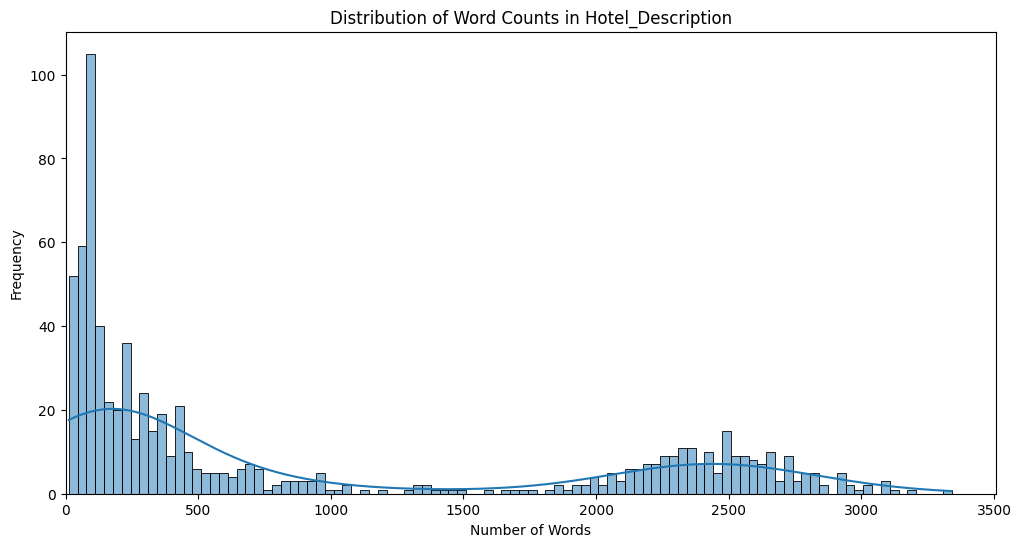

In [69]:
# Function to count words in a string
def count_words(text):
    return len(text.split())

# Apply the function to the 'Hotel_Description' column
data_info['Word_Count'] = data_info['Hotel_Description'].apply(count_words)

# Plot the distribution of word counts
plt.figure(figsize=(12, 6))
sns.histplot(data_info['Word_Count'], bins=100, kde=True)
plt.xlim(left=0)  
plt.ylim(bottom=0) 

plt.title('Distribution of Word Counts in Hotel_Description')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

#### Nhận xét:
- Hầu hết Description có độ dài từ khoảng 400 từ trở xuống. Có 1 lượng đáng kể description dài từ 2000 từ trở lên.
- Chọn khoảng 350 từ phân tích.

#### Tạo cột 'Content'

In [70]:
# 350 từ
def truncate_description(description, max_words):
    words = description.split()
    if len(words) > max_words:
        return ' '.join(words[:max_words])
    return description

data_info['Content'] = data_info['Hotel_Description'].apply(lambda x: truncate_description(x, 350))

#### Xử lý cột 'Content'

In [71]:
def clean_text(content_series):
    # Bỏ hết số
    content_series = content_series.str.replace(r'\d+', '', regex=True)
    
    # Bỏ một số chữ đặc biệt
    words_to_remove = ["AM", "PM", "m²", "m2", "m", "meter", "meters", "kilometers", "kilometer", 
                       "mile", "km", "min", "minutes", "minute", "hours", "hour", "h", "phút", 
                       "giờ", "ph"]
    pattern = r'\b(?:' + '|'.join(re.escape(word) for word in words_to_remove) + r')\b'
    content_series = content_series.str.replace(pattern, '', regex=True)
    
    # Thay chấm phẩy, ký tự đặc biệt, emoji bằng khoảng trắng
    content_series = content_series.str.replace(r'[^\w\s]', ' ', regex=True)
    
    # Thay nhiều khoảng trắng liên tục bằng một khoảng trắng
    content_series = content_series.str.replace(r'\s+', ' ', regex=True)
    
    # Xóa khoảng trắng đầu hoặc cuối câu
    content_series = content_series.str.strip()
    
    return content_series

In [72]:
data_info['Content'] = clean_text(data_info['Content'])

### GENSIM

In [73]:
from gensim import corpora, models, similarities
from underthesea import word_tokenize, pos_tag, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

##### Tải file stopwwords và wrongwords

In [74]:
STOP_WORD_FILE = 'files/vietnamese-stopwords.txt'
WRONG_WORD_FILE = 'files/wrong-word.txt'

In [77]:
# stop_words
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = file.read()

stop_words = stop_words.split('\n')

# wrong_words
with open(WRONG_WORD_FILE, 'r', encoding='utf-8') as file:
    wrong_words = file.read()

wrong_words = wrong_words.split('\n')

#### word_tokenize

In [78]:
data_info['Content_wt']=data_info['Content'].apply(lambda x: word_tokenize(x, format='text'))

In [79]:
data_info.head(3)

,Hotel_ID,Hotel_Name,Hotel_Address,Hotel_Description,Word_Count,Content,Content_wt
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,"Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","Trần Phú, Lộc Thọ, Nha Trang, Việt Nam Trần Ph...",2710,Trần Phú Lộc Thọ Nha Trang Việt Nam Trần Phú L...,Trần_Phú_Lộc_Thọ Nha_Trang Việt_Nam Trần_Phú_L...
1,1_2,ALPHA BIRD NHA TRANG,"Tue Tinh St, Loc Tho Ward, Nha Trang, Lộc Thọ,...","Tue Tinh St, Loc Tho Ward, Nha Trang, Lộc Thọ,...",2708,Tue Tinh St Loc Tho Ward Nha Trang Lộc Thọ Nha...,Tue Tinh_St Loc_Tho Ward Nha_Trang Lộc_Thọ Nha...
2,1_3,Khách sạn Aaron (Aaron Hotel),"Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam,","Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam,...",2476,Trần Quang Khải Lộc Thọ Nha Trang Việt Nam Trầ...,Trần_Quang_Khải Lộc_Thọ Nha_Trang Việt_Nam Trầ...


In [80]:
import re
import regex

#### Xử lý dữ liệu

In [81]:
def process_text(x):
    content_gem = x.split(' ')
    content_gem_re = [t for t in content_gem if not t in stop_words] # stopword
    content_gem_re = [t for t in content_gem_re if not t in wrong_words] # wrongword
    return content_gem_re

In [82]:
data_info['content_gem_re'] = data_info['Content_wt'].apply(lambda x: process_text(x))

In [83]:
data_info[['Content_wt','content_gem_re']].head()

,Content_wt,content_gem_re
0,Trần_Phú_Lộc_Thọ Nha_Trang Việt_Nam Trần_Phú_L...,"[Trần_Phú_Lộc_Thọ, Nha_Trang, Việt_Nam, Trần_P..."
1,Tue Tinh_St Loc_Tho Ward Nha_Trang Lộc_Thọ Nha...,"[Tue, Tinh_St, Loc_Tho, Ward, Nha_Trang, Lộc_T..."
2,Trần_Quang_Khải Lộc_Thọ Nha_Trang Việt_Nam Trầ...,"[Trần_Quang_Khải, Lộc_Thọ, Nha_Trang, Việt_Nam..."
3,Nguyen Thi_Minh Khai_Lộc_Thọ Nha_Trang Việt_Na...,"[Nguyen, Thi_Minh, Khai_Lộc_Thọ, Nha_Trang, Vi..."
4,B Trần_Phú_Lộc_Thọ Nha_Trang Việt_Nam B Trần_P...,"[B, Trần_Phú_Lộc_Thọ, Nha_Trang, Việt_Nam, B, ..."


In [84]:
# data_info['content_gem_re'][:1][0]

#### Tạo từ điển

In [85]:
# Obtain the number of features based on dictionary: Use corpora.Dictionary
dictionary = corpora.Dictionary(data_info['content_gem_re'])

In [86]:
# List of features in dictionary
dictionary.token2id

{'Cuối': 0,
 'Khách_sạn': 1,
 'Mường_Thanh_Luxury': 2,
 'Nha_Trang': 3,
 'Nha_Trang_Nơi': 4,
 'Nếu': 5,
 'Thời_gian': 6,
 'Trần_Phú_Lộc_Thọ': 7,
 'Tại': 8,
 'Việt_Nam': 9,
 'Với': 10,
 'bạc': 11,
 'bồn': 12,
 'cho_phép': 13,
 'chăm_sóc': 14,
 'cửa_hàng': 15,
 'du_khách': 16,
 'dạo': 17,
 'dịch_vụ': 18,
 'gia_đình': 19,
 'giải_trí': 20,
 'hiện': 21,
 'khách_sạn': 22,
 'khỏe': 23,
 'liệu_pháp': 24,
 'làm_đẹp': 25,
 'lưu_trú': 26,
 'miễn_phí': 27,
 'mua_sắm': 28,
 'ngâm': 29,
 'nhu_cầu': 30,
 'nóng': 31,
 'phòng': 32,
 'quầy': 33,
 'sân_bay': 34,
 'sòng': 35,
 'sẽ': 36,
 'số_lượng': 37,
 'sức': 38,
 'thoải_mái': 39,
 'thuận_lợi': 40,
 'thành_phố': 41,
 'thân_thiện': 42,
 'thăm': 43,
 'thơm': 44,
 'thư_giãn': 45,
 'thưởng_thức': 46,
 'thử_vận': 47,
 'tiện_nghi': 48,
 'tiện_ích': 49,
 'trung_tâm': 50,
 'trò_chơi': 51,
 'trải_nghiệm': 52,
 'trẻ': 53,
 'trẻ_em': 54,
 'tuyệt_vời': 55,
 'tận_hưởng': 56,
 'tọa_lạc': 57,
 'tổng_cộng': 58,
 'xe_Khách_sạn': 59,
 'xây_dựng': 60,
 'xông_hơi': 61,
 'Đ

#### Tạo biến số lượng từ điển

In [87]:
# Numbers of features (word) in dictionary
feature_cnt = len(dictionary.token2id)

In [88]:
print(feature_cnt)

6407


#### Lấy dữ liệu dựa trên từ điển (ma trận dày đặc)

In [89]:
# Obtain corpus based on dictionary (dense matrix)
corpus = [dictionary.doc2bow(text) for text in data_info['content_gem_re']]

In [90]:
corpus[0] # id, so lan xuat hien cua token trong van ban/ san pham

[(0, 1),
 (1, 3),
 (2, 3),
 (3, 7),
 (4, 1),
 (5, 2),
 (6, 1),
 (7, 2),
 (8, 1),
 (9, 4),
 (10, 3),
 (11, 1),
 (12, 1),
 (13, 2),
 (14, 1),
 (15, 1),
 (16, 3),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 8),
 (23, 1),
 (24, 2),
 (25, 1),
 (26, 3),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 2),
 (31, 1),
 (32, 5),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 2),
 (41, 2),
 (42, 1),
 (43, 2),
 (44, 1),
 (45, 4),
 (46, 1),
 (47, 1),
 (48, 2),
 (49, 1),
 (50, 2),
 (51, 1),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 3),
 (56, 3),
 (57, 1),
 (58, 1),
 (59, 1),
 (60, 1),
 (61, 1),
 (62, 1),
 (63, 1),
 (64, 1),
 (65, 2),
 (66, 1),
 (67, 1),
 (68, 1),
 (69, 1)]

#### Model Tf-idf

In [91]:
# Use TF-IDF Model to process corpus, obtaining index
tfidf = models.TfidfModel(corpus)
# tính toán sự tương tự trong ma trận thưa thớt
index = similarities.SparseMatrixSimilarity(tfidf[corpus],
                                            num_features = feature_cnt)
# ma tran: n x n

In [92]:
df_gensim = pd.DataFrame(index)
df_gensim

,0,1,2,3,4,5,6,7,8,9,...,730,731,732,733,734,735,736,737,738,739
0,1.000000,0.203456,0.175993,0.110372,0.246694,0.105248,0.201655,0.143964,0.112420,0.056022,...,0.019662,0.103192,0.048832,0.148426,0.037994,0.018204,0.017818,0.007794,0.062122,0.078998
1,0.203456,1.000000,0.181331,0.147620,0.216912,0.128101,0.209050,0.129149,0.131255,0.035826,...,0.043266,0.166956,0.030341,0.155156,0.028844,0.056410,0.017129,0.008020,0.053208,0.104792
2,0.175993,0.181331,1.000000,0.163979,0.263255,0.147372,0.241965,0.163549,0.183837,0.151260,...,0.064405,0.120559,0.121095,0.152886,0.092792,0.057300,0.051113,0.027843,0.133190,0.112961
3,0.110372,0.147620,0.163979,1.000000,0.168358,0.263024,0.153977,0.143478,0.123564,0.067882,...,0.039150,0.113921,0.065515,0.124529,0.048910,0.047668,0.011802,0.011789,0.046530,0.081731
4,0.246694,0.216912,0.263255,0.168358,1.000000,0.176823,0.256329,0.170164,0.159840,0.069852,...,0.072238,0.166474,0.057162,0.155608,0.057022,0.085455,0.026800,0.034142,0.103979,0.121774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,0.018204,0.056410,0.057300,0.047668,0.085455,0.024662,0.035588,0.051365,0.036585,0.092827,...,0.221302,0.049059,0.092297,0.141296,0.121022,1.000000,0.240385,0.064900,0.119530,0.078520
736,0.017818,0.017129,0.051113,0.011802,0.026800,0.016302,0.020927,0.111800,0.016793,0.075170,...,0.169208,0.047486,0.080298,0.158865,0.136859,0.240385,1.000000,0.089521,0.220113,0.058878
737,0.007794,0.008020,0.027843,0.011789,0.034142,0.007538,0.012747,0.017042,0.011742,0.054311,...,0.054483,0.020415,0.039803,0.008171,0.056460,0.064900,0.089521,1.000000,0.135689,0.008978
738,0.062122,0.053208,0.133190,0.046530,0.103979,0.038397,0.066085,0.037679,0.040715,0.205211,...,0.120812,0.072144,0.243319,0.046777,0.193214,0.119530,0.220113,0.135689,1.000000,0.035685


### Cho người dùng nhập Hotel_ID, tìm 5 khách sạn có similarity cao nhất

In [93]:
def find_similar_hotels(hotel_id, df_info, dictionary, tfidf, index):
    # Lấy index
    hotel_idx = data_info[data_info['Hotel_ID'] == hotel_id].index[0]

    # Get the content of the specified hotel and convert it to BoW format
    hotel_bow = dictionary.doc2bow(data_info['content_gem_re'][hotel_idx])

    # Get the TF-IDF vector of the specified hotel
    hotel_tfidf = tfidf[hotel_bow]

    # Calculate similarities of the specified hotel with all other hotels
    sims = index[hotel_tfidf]
    
    # Get the top 10 most similar hotels (excluding the hotel itself)
    top_10_idx = sims.argsort()[-6:-1][::-1]  # Top 10 excluding the hotel itself
    
    # Create a DataFrame to display the results
    similar_hotels = data_info.iloc[top_10_idx][['Hotel_ID', 'Hotel_Name', 'Hotel_Address', 'Hotel_Description']]
    similar_hotels['Similarity'] = sims[top_10_idx]
    
    return similar_hotels

In [94]:
# Example usage: '1_1'
hotel_id = str(input("Nhập ID của Khách sạn:"))
similar_hotels_df = find_similar_hotels(hotel_id, data_info, dictionary, tfidf, index)
similar_hotels_df

,Hotel_ID,Hotel_Name,Hotel_Address,Hotel_Description,Similarity
260,26_27,Nha Trang Lodge Hotel,"Trần Phú , Lộc Thọ, Nha Trang, Việt Nam, +","Trần Phú , Lộc Thọ, Nha Trang, Việt Nam, + Trầ...",0.292771
208,18_12,Khách Sạn Vesna (Vesna Hotel),"Trần Ph&#;, Lộc Thọ, Nha Trang, Việt Nam,","Trần Ph&#;, Lộc Thọ, Nha Trang, Việt Nam, Trần...",0.271288
28,1_29,Khách sạn Paris Nha Trang (Paris Nha Trang Hot...,"B/ Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","B/ Trần Phú, Lộc Thọ, Nha Trang, Việt Nam B/ T...",0.270678
639,15_18,Muong Thanh Apartments,"Tran Phu_ Tầng Trệt, Lộc Thọ, Nha Trang, Việt ...","Tran Phu_ Tầng Trệt, Lộc Thọ, Nha Trang, Việt ...",0.263411
114,5_18,Khách san Luxury Nha Trang (Luxury Nha Trang H...,"Trần Phú , Lộc Thọ, Nha Trang, Việt Nam,","Trần Phú , Lộc Thọ, Nha Trang, Việt Nam, Trần ...",0.257253


### Cho người dùng nhập chuỗi string tìm kiếm, tìm 5 khách sạn có similarity cao nhất:

In [95]:
def preprocess_query(query):
    # Preprocess the search query to match the cleaning process of 'Content'
    query = query.lower()
    query = re.sub(r'\d+', '', query)  # Remove numbers
    words_to_remove = ["AM", "PM", "m²", "m2", "m", "meter", "meters", "kilometers", "kilometer", 
                       "mile", "km", "min", "minutes", "minute", "hours", "hour", "h", "phút", 
                       "giờ", "ph"]
    query = re.sub(r'\b(?:' + '|'.join(re.escape(word) for word in words_to_remove) + r')\b', '', query)  # Remove special words
    query = re.sub(r'[^\w\s]', ' ', query)  # Replace special characters with spaces
    query = re.sub(r'\s+', ' ', query)  # Replace multiple spaces with a single space
    query = query.strip()  # Remove leading and trailing spaces

    # Tokenization (split into words) and stopword removal
    tokens = word_tokenize(query, format="text")
    tokens = tokens.split()   
    return tokens

def find_similar_hotels_from_query(query, data_info, dictionary, tfidf, index):
    # Preprocess the search query
    processed_query = preprocess_query(query)

    # Convert the processed query into a list of words
    query_bow = dictionary.doc2bow(processed_query)

    # Convert the query BoW into a TF-IDF vector
    query_tfidf = tfidf[query_bow]

    # Calculate similarities with all hotels
    sims = index[query_tfidf]
    
    # Get the top 5 most similar hotels
    top_5_idx = sims.argsort()[-5:][::-1]  # Top 5 similar hotels
    
    # Create a DataFrame to display the results
    similar_hotels = data_info.iloc[top_5_idx][['Hotel_ID', 'Hotel_Name', 'Hotel_Address', 'Hotel_Description']]
    similar_hotels['Similarity'] = sims[top_5_idx]
    
    return similar_hotels

In [96]:
# Example usage: 'Mường Thanh trung tâm hồ bơi gần biển'
query = str(input("Nhập chuỗi tìm kiếm:"))
similar_hotels_df = find_similar_hotels_from_query(query, data_info, dictionary, tfidf, index)
similar_hotels_df

,Hotel_ID,Hotel_Name,Hotel_Address,Hotel_Description,Similarity
698,20_15,"Nhà riêng 60 m² 2 phòng ngủ, 2 phòng tắm riêng...","Vĩnh Phước, Nha Trang, Việt Nam","Vĩnh Phước, Nha Trang, Việt Nam Vĩnh Phước, Nh...",0.243474
15,1_16,The Summer Hotel,"C-D Nguyễn Thiện Thuật , Tân Lập, Nha Trang, V...","C-D Nguyễn Thiện Thuật , Tân Lập, Nha Trang, V...",0.096665
489,20_24,"Căn hộ 37 m² 1 phòng ngủ, 1 phòng tắm riêng ở ...","Cam Hải Đông, Nha Trang, Việt Nam","Cam Hải Đông, Nha Trang, Việt Nam Cam Hải Đông...",0.091886
355,41_19,Khách Sạn Aloha Nha Trang (Aloha Hotel Nha Trang),"Hong Bang Street, Tân Lập, Nha Trang, Việt Nam","Hong Bang Street, Tân Lập, Nha Trang, Việt Nam...",0.091140
242,22_16,Venue Hotel,"Ton Dan Street, Lộc Thọ, Nha Trang, Việt Nam","Ton Dan Street, Lộc Thọ, Nha Trang, Việt Nam T...",0.089549


### Cosine_similarity

In [102]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [103]:
# Vector hóa nội dung
vectorizer = TfidfVectorizer(analyzer='word', stop_words=stop_words)
tfidf_matrix = vectorizer.fit_transform(data_info['Content_wt'])

In [104]:
data_info

,Hotel_ID,Hotel_Name,Hotel_Address,Hotel_Description,Word_Count,Content,Content_wt,content_gem_re
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,"Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","Trần Phú, Lộc Thọ, Nha Trang, Việt Nam Trần Ph...",2710,Trần Phú Lộc Thọ Nha Trang Việt Nam Trần Phú L...,Trần_Phú_Lộc_Thọ Nha_Trang Việt_Nam Trần_Phú_L...,"[Trần_Phú_Lộc_Thọ, Nha_Trang, Việt_Nam, Trần_P..."
1,1_2,ALPHA BIRD NHA TRANG,"Tue Tinh St, Loc Tho Ward, Nha Trang, Lộc Thọ,...","Tue Tinh St, Loc Tho Ward, Nha Trang, Lộc Thọ,...",2708,Tue Tinh St Loc Tho Ward Nha Trang Lộc Thọ Nha...,Tue Tinh_St Loc_Tho Ward Nha_Trang Lộc_Thọ Nha...,"[Tue, Tinh_St, Loc_Tho, Ward, Nha_Trang, Lộc_T..."
2,1_3,Khách sạn Aaron (Aaron Hotel),"Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam,","Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam,...",2476,Trần Quang Khải Lộc Thọ Nha Trang Việt Nam Trầ...,Trần_Quang_Khải Lộc_Thọ Nha_Trang Việt_Nam Trầ...,"[Trần_Quang_Khải, Lộc_Thọ, Nha_Trang, Việt_Nam..."
3,1_4,Panorama Star Beach Nha Trang,"Nguyen Thi Minh Khai, Lộc Thọ, Nha Trang, Việt...","Nguyen Thi Minh Khai, Lộc Thọ, Nha Trang, Việt...",2259,Nguyen Thi Minh Khai Lộc Thọ Nha Trang Việt Na...,Nguyen Thi_Minh Khai_Lộc_Thọ Nha_Trang Việt_Na...,"[Nguyen, Thi_Minh, Khai_Lộc_Thọ, Nha_Trang, Vi..."
4,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...,"B/ Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","B/ Trần Phú, Lộc Thọ, Nha Trang, Việt Nam B/ T...",2589,B Trần Phú Lộc Thọ Nha Trang Việt Nam B Trần P...,B Trần_Phú_Lộc_Thọ Nha_Trang Việt_Nam B Trần_P...,"[B, Trần_Phú_Lộc_Thọ, Nha_Trang, Việt_Nam, B, ..."
...,...,...,...,...,...,...,...,...
735,16_5,Victor Condotel Cam Ranh,"Cam Nghĩa, Cam Ranh, Khánh Hòa, Cam Ranh, Cam ...","Cam Nghĩa, Cam Ranh, Khánh Hòa, Cam Ranh, Cam ...",290,Cam Nghĩa Cam Ranh Khánh Hòa Cam Ranh Cam Hải ...,Cam_Nghĩa Cam_Ranh Khánh_Hòa Cam_Ranh Cam_Hải_...,"[Cam_Nghĩa, Cam_Ranh, Khánh_Hòa, Cam_Ranh, Cam..."
736,30_24,Victor Group - Sam Sam Cam Ranh Condotel,"Đại lộ, Nguyễn Tất Thành, Cam Hải Đông, Tp. Ca...","Đại lộ, Nguyễn Tất Thành, Cam Hải Đông, Tp. Ca...",239,Đại lộ Nguyễn Tất Thành Cam Hải Đông Tp Cam Ra...,Đại_lộ Nguyễn_Tất_Thành Cam_Hải_Đông Tp Cam_Ra...,"[Đại_lộ, Nguyễn_Tất_Thành, Cam_Hải_Đông, Tp, C..."
737,27_21,Victory's House Ngoc Hoa,"Lô D-B-, GOLDEN BAY HƯNG THỊNH , THÔN CÙ HIN, ...","Lô D-B-, GOLDEN BAY HƯNG THỊNH , THÔN CÙ HIN, ...",281,Lô D B GOLDEN BAY HƯNG THỊNH THÔN CÙ HIN XÃ CA...,Lô D_B GOLDEN BAY_HƯNG_THỊNH THÔN CÙ_HIN XÃ CA...,"[Lô, D_B, GOLDEN, BAY_HƯNG_THỊNH, THÔN, CÙ_HIN..."
738,8_21,Western Seaview (The Arena Cam Ranh),"Nguyễn Tất Th&#;nh, Cam Hải Đông, Nha Trang, V...","Nguyễn Tất Th&#;nh, Cam Hải Đông, Nha Trang, V...",516,Nguyễn Tất Th nh Cam Hải Đông Nha Trang Việt N...,Nguyễn_Tất_Th nh Cam_Hải_Đông Nha_Trang Việt_N...,"[Nguyễn_Tất_Th, Cam_Hải_Đông, Nha_Trang, Việt_..."


In [105]:
# Tính toán độ tương đồng
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [106]:
df_cosine = pd.DataFrame(cosine_sim)
df_cosine

,0,1,2,3,4,5,6,7,8,9,...,730,731,732,733,734,735,736,737,738,739
0,1.000000,0.432745,0.417626,0.322258,0.481449,0.258658,0.409887,0.329789,0.321279,0.173963,...,0.063874,0.269139,0.134237,0.332611,0.136638,0.085826,0.091184,0.044230,0.181585,0.219106
1,0.432745,1.000000,0.449475,0.378013,0.488282,0.292600,0.434031,0.329333,0.353986,0.158264,...,0.103715,0.370291,0.123426,0.341927,0.128210,0.136640,0.093167,0.059748,0.181592,0.255867
2,0.417626,0.449475,1.000000,0.385085,0.534472,0.314700,0.476187,0.362440,0.418171,0.300254,...,0.151546,0.308532,0.253527,0.364330,0.202534,0.129990,0.142429,0.092052,0.289761,0.272943
3,0.322258,0.378013,0.385085,1.000000,0.399798,0.403905,0.364223,0.339821,0.325620,0.200993,...,0.093332,0.286411,0.174054,0.320895,0.153684,0.123075,0.078628,0.062690,0.168990,0.211778
4,0.481449,0.488282,0.534472,0.399798,1.000000,0.352469,0.512134,0.382037,0.396993,0.175806,...,0.135057,0.340712,0.152113,0.376159,0.149997,0.149302,0.094290,0.056803,0.232610,0.309746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,0.085826,0.136640,0.129990,0.123075,0.149302,0.069337,0.089585,0.114169,0.089345,0.179233,...,0.394074,0.103800,0.184573,0.223050,0.234572,1.000000,0.368851,0.164292,0.229384,0.131650
736,0.091184,0.093167,0.142429,0.078628,0.094290,0.075342,0.078644,0.133845,0.071168,0.159320,...,0.243485,0.110817,0.168934,0.215115,0.250935,0.368851,1.000000,0.193775,0.305016,0.117369
737,0.044230,0.059748,0.092052,0.062690,0.056803,0.049186,0.057193,0.062216,0.052519,0.147174,...,0.109193,0.065673,0.115299,0.063841,0.169461,0.164292,0.193775,1.000000,0.231792,0.039077
738,0.181585,0.181592,0.289761,0.168990,0.232610,0.137502,0.190406,0.134010,0.159594,0.370207,...,0.225764,0.173164,0.389231,0.153401,0.343138,0.229384,0.305016,0.231792,1.000000,0.125615


#### Lưu ma trận kết quả consin và đọc lên khi cần đề xuất

In [107]:
# # Save cosine_sim to file
# import pickle
# with open('cosine_sim.pkl', 'wb') as f:
#     pickle.dump(cosine_sim, f)

# # Open and read file to cosine_sim_new
# with open('cosine_sim.pkl', 'rb') as f:
#     cosine_sim_new = pickle.load(f)
# # cosine_sim_new

In [108]:
# Hàm đề xuất khách sạn
# # với mỗi sản phẩm, lấy nums sản phẩm tương quan nhất
def get_recommendations(hotel_id, cosine_sim=cosine_sim_new, nums=5):
    idx = data_info.index[data_info['Hotel_ID'] == hotel_id][0]
    sim_scores = list(enumerate(cosine_sim_new[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:nums+1]  # Lấy 5 khách sạn tương tự nhất  
    hotel_indices = [i[0] for i in sim_scores]
    return data_info['Hotel_Name'].iloc[hotel_indices]

In [109]:
# Gọi function
recommendations = get_recommendations('1_1')
print(recommendations)

208                        Khách Sạn Vesna (Vesna Hotel)
639                               Muong Thanh Apartments
37                                 Dubai Nha Trang Hotel
217    Khu nghỉ dưỡng, Khách sạn và Spa Yasaka Sài Gò...
260                                Nha Trang Lodge Hotel
Name: Hotel_Name, dtype: object


### Đề xuất khách sạn theo chuỗi tìm kiếm người dùng nhập

In [110]:
def find_similar_hotels_from_query_cos(query, vectorizer, tfidf_matrix, df_info):
    # Preprocess the query
    processed_query = preprocess_query(query)
    processed_query  = ' '.join(processed_query)
    # Convert the processed query into a TF-IDF vector
    query_tfidf = vectorizer.transform([processed_query])
    # Compute cosine similarity with the existing matrix
    query_sim = cosine_similarity(query_tfidf, tfidf_matrix)
    # Get similarity scores and find the top 5 similar hotels
    similar_indices = query_sim[0].argsort()[-5:][::-1]
    similar_hotels = df_info.iloc[similar_indices]
    similar_hotels['Similarity'] = query_sim[0][similar_indices]
    
    return similar_hotels

In [50]:
# Mường Thanh trung tâm hồ bơi gần biển
query = input("Nhập chuỗi tìm kiếm:")
similar_hotels_df = find_similar_hotels_from_query_cos(query, vectorizer, tfidf_matrix, data_info)
similar_hotels_df[['Hotel_ID', 'Hotel_Name', 'Hotel_Address', 'Hotel_Description', 'Similarity']]

,Hotel_ID,Hotel_Name,Hotel_Address,Hotel_Description,Similarity
641,17_14,Muong Thanh Vien Trieu Apartment Review Nha Trang,"Phạm Văn Đồng, Mường Thanh Viễn Triều, Vĩnh Ph...","Phạm Văn Đồng, Mường Thanh Viễn Triều, Vĩnh Ph...",0.315918
207,18_11,Mường Thanh Nha Trang Poli Apartment,"Phạm Văn Đồng, Vĩnh Hải, Vĩnh Phước, Nha Trang...","Phạm Văn Đồng, Vĩnh Hải, Vĩnh Phước, Nha Trang...",0.251920
582,27_23,Căn hộ Mường Thanh Viễn Triều Nha Trang (Mường...,"pham van dong, Vĩnh Phước, Nha Trang, Việt Nam,","pham van dong, Vĩnh Phước, Nha Trang, Việt Nam...",0.248237
485,15_8,"Căn hộ 35 m² 1 phòng ngủ, 1 phòng tắm riêng ở ...","Lộc Thọ, Nha Trang, Việt Nam","Lộc Thọ, Nha Trang, Việt Nam Cách biển 10m\nGầ...",0.234044
640,13_21,Muong Thanh Nha Trang Hotel & Apartment,"Tòa nhà OCA, Mường Thanh Viễn Triều, Phạm Văn...","Tòa nhà OCA, Mường Thanh Viễn Triều, Phạm Văn...",0.228073


## Bài toán 2: Đề xuất người dùng với Collaborative filtering

In [111]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

# Data Understanding

In [112]:
# Đoc file 'hotel_comments.csv'
data_comments = spark.read.csv('hotel_comments.csv',header=True,inferSchema=True)

In [113]:
data_comments.printSchema()

root
 |-- num: integer (nullable = true)
 |-- Hotel ID: string (nullable = true)
 |-- Reviewer ID: string (nullable = true)
 |-- Reviewer Name: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Group Name: string (nullable = true)
 |-- Room Type: string (nullable = true)
 |-- Stay Details: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Score Level: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Body: string (nullable = true)
 |-- Review Date: string (nullable = true)



In [114]:
# Xem số dòng và số cột
print('Dữ liệu có:',data_comments.count(),'dòng và',len(data_comments.columns),'cột')

Dữ liệu có: 80314 dòng và 13 cột


In [115]:
data_comments.show(5)

+---+--------+-----------+-------------+-----------+-----------------+--------------------+--------------------+-----+-----------------+--------------------+--------------------+--------------------+
|num|Hotel ID|Reviewer ID|Reviewer Name|Nationality|       Group Name|           Room Type|        Stay Details|Score|      Score Level|               Title|                Body|         Review Date|
+---+--------+-----------+-------------+-----------+-----------------+--------------------+--------------------+-----+-----------------+--------------------+--------------------+--------------------+
|  1|     1_1|      1_1_1|       MARIKO|   Nhật Bản|          Cặp đôi|Phòng Deluxe 2 Gi...|Đã ở 3 đêm vào Th...| 10,0|Trên cả tuyệt vời|         Cao nhất‼︎”|Tôi đã ở cùng chủ...|Đã nhận xét vào 3...|
|  2|     1_1|      1_1_2|         Hong|   Việt Nam|      Đi công tác|Phòng Deluxe 2 Gi...|Đã ở 1 đêm vào Th...| 10,0|Trên cả tuyệt vời|            Tháng 8”|Lựa chọn Mường Th...|Đã nhận xét vào 0...|


#### Nhận xét:
- Xem qua trên dữ liệu (mở bằng excel) thấy có nhiều dòng bị lặp, tất cả thông tin đều giống, trừ reviewer ID.
- Cột 'Reviewer ID' và 'num' không có giá trị phân tích , nên drop
- Cột 'Score' có giá trị phân tích cần chuyển kiểu dữ liêu

In [116]:
# Kiểm tra trùng
print(f"The dataset has {data_comments.count()} rows.")
print(f"There are {data_comments.select('Hotel ID').distinct().count()} distinct Hotel IDs.")
print(f"There are {data_comments.select('Reviewer ID').distinct().count()} distinct Reviewer IDs.")

The dataset has 80314 rows.
There are 473 distinct Hotel IDs.
There are 80314 distinct Reviewer IDs.


In [117]:
# Loại bỏ cột 'Reviewer ID'và 'num'
data_comments=data_comments.drop('Reviewer ID', 'num')

In [118]:
# Loại bỏ các dòng trùng
data_comments = data_comments.drop_duplicates()
data_comments.count()

31078

In [119]:
# Chuyển 'Score' thàng float
data_comments = data_comments.withColumn('Score', regexp_replace(col('Score'), ',', '.').cast('float'))

In [120]:
# Kiểm tra 'Null'
data_comments.select([count(when(col(c).isNull(), c)).alias(c) for c in data_comments.columns]).toPandas()

,Hotel ID,Reviewer Name,Nationality,Group Name,Room Type,Stay Details,Score,Score Level,Title,Body,Review Date
0,0,28,0,0,0,0,0,0,0,18,0


In [121]:
#  Loại bỏ 'null' cột 'Reviewer Name'
data_comments = data_comments.dropna(subset=['Reviewer Name'])

- Xử lý: Do Reviewer ID không dùng được (không lặp lại, mỗi dòng là 1 Reviewer ID mới), nên xử lý theo Reviewer Name.
- Tất cả Reviewer Name được thêm suffix _1. Nếu lặp lại thì thêm _2, _3

In [122]:
from pyspark.sql.window import Window

In [123]:
# Tạo window specification để đánh số thứ tự cho mỗi nhóm 'Hotel ID' và 'Reviewer Name'
windowSpec = Window.partitionBy('Hotel ID', 'Reviewer Name').orderBy('Reviewer Name')

# Thêm cột 'row_num' để đánh số thứ tự
data_comments = data_comments.withColumn('row_num', row_number().over(windowSpec))

# Tạo cột mới 'Reviewer Name Updated' với số thứ tự nếu cần thiết
data_comments = data_comments.withColumn('Reviewer Name',  concat(col('Reviewer Name'),  lit('_'), col('row_num').cast('string')))

# Loại bỏ cột 'row_num' không cần thiết
data_comments = data_comments.drop('row_num')

data_comments.show()

+--------+-------------+-----------+-----------------+--------------------+--------------------+-----+-----------------+-------------------------+-------------------------------------+--------------------+
|Hotel ID|Reviewer Name|Nationality|       Group Name|           Room Type|        Stay Details|Score|      Score Level|                    Title|                                 Body|         Review Date|
+--------+-------------+-----------+-----------------+--------------------+--------------------+-----+-----------------+-------------------------+-------------------------------------+--------------------+
|   10_10|       Diệu_1|   Việt Nam|          Cặp đôi|Phòng Hai Giường Đơn|Đã ở 1 đêm vào Th...| 10.0|Trên cả tuyệt vời|           Rất thoải mái”|                 Đây là lần thứ 2 ...|Đã nhận xét vào 3...|
|   10_10|        Han_1|   Việt Nam|      Đi công tác|    Phòng Tiêu Chuẩn|Đã ở 1 đêm vào Th...| 10.0|Trên cả tuyệt vời|           Vượt mong đợi”|                 Khách sạn sạc

In [124]:
# Xem dữ liệu với tên 'Hong'
data_comments.filter(data_comments['Reviewer Name'].startswith('Hong_')).show(5)

+--------+-------------+-----------+-----------------+--------------------+--------------------+-----+-----------+--------------------+--------------------+--------------------+
|Hotel ID|Reviewer Name|Nationality|       Group Name|           Room Type|        Stay Details|Score|Score Level|               Title|                Body|         Review Date|
+--------+-------------+-----------+-----------------+--------------------+--------------------+-----+-----------+--------------------+--------------------+--------------------+
|   10_12|       Hong_1|   Việt Nam| Du lịch một mình|Phòng Loại Sang H...|Đã ở 3 đêm vào Th...|  8.4|  Tuyệt vời|          Tuyệt vời”|Khách sạn có vẻ m...|Đã nhận xét vào 0...|
|   13_30|       Hong_1|   Việt Nam|Gia đình có em bé|Phòng Deluxe giườ...|Đã ở 3 đêm vào Th...|  8.8|  Tuyệt vời|Villa đẹp, có bể ...|Villa đầy đủ tiện...|Đã nhận xét vào 1...|
|    17_3|       Hong_1|   Việt Nam|Gia đình có em bé|              Căn hộ|Đã ở 1 đêm vào Th...|  6.8|   Hài L

In [125]:
# Seclect columns 'Hotel ID', 'Reviewer Name', 'Score'
df_selected = data_comments.select('Hotel ID', 'Reviewer Name', 'Score')

In [126]:
df_selected.show(5)

+--------+-------------+-----+
|Hotel ID|Reviewer Name|Score|
+--------+-------------+-----+
|    10_1|       Dang_1|  9.2|
|    10_1|      HANJU_1|  7.6|
|    10_1|       한형_1|  7.6|
|    10_1|     훈앤후_1|  7.2|
|   10_10|       Diệu_1| 10.0|
+--------+-------------+-----+
only showing top 5 rows



#### Encode Hotel ID và Reviewer Name

In [127]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [128]:
# Create an indexer
indexer = StringIndexer(inputCol='Hotel ID',
                        outputCol='Hotel_id')

# Indexer identifies categories in the data
indexer_model = indexer.fit(df_selected)

# Indexer creates a new column with numeric index values
data_indexed = indexer_model.transform(df_selected)

# Repeat the process for the other categorical feature
indexer1 = StringIndexer(inputCol='Reviewer Name',
                         outputCol='Reviewer_id')
indexer1_model = indexer1.fit(data_indexed)
data_indexed = indexer1_model.transform(data_indexed)

In [129]:
data_indexed.show(5)

+--------+-------------+-----+--------+-----------+
|Hotel ID|Reviewer Name|Score|Hotel_id|Reviewer_id|
+--------+-------------+-----+--------+-----------+
|    10_1|       Dang_1|  9.2|   338.0|       72.0|
|    10_1|      HANJU_1|  7.6|   338.0|      963.0|
|    10_1|       한형_1|  7.6|   338.0|     1529.0|
|    10_1|     훈앤후_1|  7.2|   338.0|     1531.0|
|   10_10|       Diệu_1| 10.0|   296.0|      366.0|
+--------+-------------+-----+--------+-----------+
only showing top 5 rows



In [130]:
# lưu file
data_indexed.toPandas().to_csv('data_indexed.csv',index=False)

In [131]:
data_indexed.printSchema()

root
 |-- Hotel ID: string (nullable = true)
 |-- Reviewer Name: string (nullable = true)
 |-- Score: float (nullable = true)
 |-- Hotel_id: double (nullable = false)
 |-- Reviewer_id: double (nullable = false)



## Recommendation System ALS

In [132]:
# Distinct users and video games
reviewers = data_indexed.select("Reviewer_id").distinct().count()
hotels = data_indexed.select("Hotel_id").distinct().count()
numerator = data_indexed.count()
display(numerator, reviewers, hotels)

31050

9859

473

In [133]:
# Number of ratings matrix could contain if no empty cells
denominator = reviewers * hotels
denominator

4663307

In [134]:
#Calculating sparsity
sparsity = 1 - (numerator*1.0 / denominator)
print ("Sparsity: "), sparsity

Sparsity: 


(None, 0.9933416350242436)

In [135]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

#### Chuẩn bị train/test

In [136]:
(training, test) = data_indexed.randomSplit([0.8, 0.2])

#### Xây dựng model

In [137]:
als = ALS(maxIter=10,
          regParam=0.09,
          rank = 25,
          userCol="Reviewer_id",
          itemCol="Hotel_id",
          ratingCol="Score",
          coldStartStrategy="drop",
          nonnegative=True)
model = als.fit(training)

#### Đánh giá model với test

In [138]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)

In [139]:
predictions.show(5)

+--------+-------------+-----+--------+-----------+----------+
|Hotel ID|Reviewer Name|Score|Hotel_id|Reviewer_id|prediction|
+--------+-------------+-----+--------+-----------+----------+
|   10_10|       Minh_1| 10.0|   296.0|        2.0|  9.862213|
|   10_12|        HYE_1|  7.6|     2.0|      591.0|  8.219105|
|   10_12|      JISUN_1|  8.4|     2.0|     1249.0| 4.9534793|
|   10_12|      James_1|  9.2|     2.0|      226.0|  9.381175|
|   10_12|       Jeff_1| 10.0|     2.0|     2790.0|  8.108481|
+--------+-------------+-----+--------+-----------+----------+
only showing top 5 rows



In [140]:
evaluator = RegressionEvaluator(metricName="rmse",
                                labelCol="Score",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.3579952908835484


#### Thử điều chình parameter

In [58]:
als = ALS(userCol="Reviewer_id",
          itemCol="Hotel_id",
          ratingCol="Score",
          coldStartStrategy="drop",
          nonnegative=True)

param_grid = (ParamGridBuilder()
              .addGrid(als.rank, [10, 20, 30])
              .addGrid(als.maxIter, [5, 10, 15])
              .addGrid(als.regParam, [0.01, 0.1, 1.0])
              .build())

evaluator = RegressionEvaluator(metricName="rmse",
                                labelCol="Score",
                                predictionCol="prediction")

crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)
cv_model = crossval.fit(training)

best_model = cv_model.bestModel
predictions = best_model.transform(test)
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.1677727083760365


RMSE giảm được một ít xuống còn 1.1

#### Luu model

#### Dự đoán

In [141]:
# get 5 recommendations which have highest rating.
user_recs = model.recommendForAllUsers(5)

In [142]:
user_recs.show(10, truncate=False)

+-----------+---------------------------------------------------------------------------------------------+
|Reviewer_id|recommendations                                                                              |
+-----------+---------------------------------------------------------------------------------------------+
|12         |[{335, 15.049821}, {323, 15.041562}, {415, 14.503322}, {377, 14.039637}, {248, 13.984077}]   |
|26         |[{335, 14.425415}, {323, 14.4195795}, {395, 14.0268345}, {375, 14.0268345}, {415, 13.516057}]|
|27         |[{415, 14.564464}, {319, 14.243073}, {248, 14.185097}, {323, 14.119986}, {335, 14.091732}]   |
|28         |[{323, 16.796312}, {335, 16.703117}, {395, 16.327085}, {375, 16.327085}, {412, 15.250372}]   |
|31         |[{415, 15.957183}, {248, 15.680309}, {412, 15.259534}, {323, 14.396423}, {335, 14.336478}]   |
|34         |[{323, 15.390001}, {335, 15.338949}, {415, 14.087194}, {319, 14.063887}, {377, 13.935758}]   |
|44         |[{323, 15.12452

In [143]:
for user in user_recs.head(5):
    print(user)
    print("\n")

Row(Reviewer_id=12, recommendations=[Row(Hotel_id=335, rating=15.049820899963379), Row(Hotel_id=323, rating=15.0415620803833), Row(Hotel_id=415, rating=14.503321647644043), Row(Hotel_id=377, rating=14.039636611938477), Row(Hotel_id=248, rating=13.984077453613281)])


Row(Reviewer_id=26, recommendations=[Row(Hotel_id=335, rating=14.4254150390625), Row(Hotel_id=323, rating=14.41957950592041), Row(Hotel_id=395, rating=14.026834487915039), Row(Hotel_id=375, rating=14.026834487915039), Row(Hotel_id=415, rating=13.516057014465332)])


Row(Reviewer_id=27, recommendations=[Row(Hotel_id=415, rating=14.56446361541748), Row(Hotel_id=319, rating=14.243073463439941), Row(Hotel_id=248, rating=14.185096740722656), Row(Hotel_id=323, rating=14.119985580444336), Row(Hotel_id=335, rating=14.091732025146484)])


Row(Reviewer_id=28, recommendations=[Row(Hotel_id=323, rating=16.79631233215332), Row(Hotel_id=335, rating=16.70311737060547), Row(Hotel_id=395, rating=16.327085494995117), Row(Hotel_id=375, ratin

In [144]:
user_recs.count()

8622

#### Ghép bảng 'Reviewer Name' và 'Hotel ID'

In [145]:
df_reviewer_id_reviewer_name = data_indexed.select('Reviewer_id', 'Reviewer Name').distinct()
df_reviewer_id_reviewer_name.count()

9859

In [146]:
df_reviewer_id_reviewer_name.show(5)

+-----------+-------------+
|Reviewer_id|Reviewer Name|
+-----------+-------------+
|     4793.0|      Fahmi_1|
|      125.0|        Mai_2|
|     2119.0|      Yulia_2|
|     1336.0|       Nate_1|
|      744.0|       YOON_1|
+-----------+-------------+
only showing top 5 rows



In [147]:
df_hotel_ID_hotel_id = data_indexed.select('Hotel_id', 'Hotel ID').distinct()
df_hotel_ID_hotel_id.count()

473

In [148]:
df_hotel_ID_hotel_id.show(5)

+--------+--------+
|Hotel_id|Hotel ID|
+--------+--------+
|   181.0|    5_18|
|   297.0|   12_21|
|   127.0|    22_1|
|   175.0|     4_4|
|   293.0|     5_8|
+--------+--------+
only showing top 5 rows



In [149]:
new_user_recs = user_recs.join(df_reviewer_id_reviewer_name, on=['Reviewer_id'], how='left')
new_user_recs.show(10, truncate=False)

+-----------+---------------------------------------------------------------------------------------------+-------------+
|Reviewer_id|recommendations                                                                              |Reviewer Name|
+-----------+---------------------------------------------------------------------------------------------+-------------+
|12         |[{335, 15.049821}, {323, 15.041562}, {415, 14.503322}, {377, 14.039637}, {248, 13.984077}]   |Thị_1        |
|26         |[{335, 14.425415}, {323, 14.4195795}, {395, 14.0268345}, {375, 14.0268345}, {415, 13.516057}]|NGUYEN_1     |
|27         |[{415, 14.564464}, {319, 14.243073}, {248, 14.185097}, {323, 14.119986}, {335, 14.091732}]   |Quang_1      |
|28         |[{323, 16.796312}, {335, 16.703117}, {395, 16.327085}, {375, 16.327085}, {412, 15.250372}]   |Ngọc_1       |
|31         |[{415, 15.957183}, {248, 15.680309}, {412, 15.259534}, {323, 14.396423}, {335, 14.336478}]   |Nguyen_3     |
|34         |[{323, 15.3

In [150]:
new_user_recs

DataFrame[Reviewer_id: int, recommendations: array<struct<Hotel_id:int,rating:float>>, Reviewer Name: string]

#### Filter ra recommend cho các user cụ thể

In [151]:
reviewerName_list = ["MARIKO_1", "Nguyen_1", "Hong_1"]

In [152]:
for reviewerName in reviewerName_list:
    find_user_rec = new_user_recs.filter(new_user_recs['Reviewer Name'] == reviewerName)
    user = find_user_rec.first()
    lst = []
    for row in user['recommendations']:
        row_f = df_hotel_ID_hotel_id.filter(df_hotel_ID_hotel_id.Hotel_id == row['Hotel_id'])
        row_f_first = row_f.first()
        lst.append((row['Hotel_id'], row_f_first['Hotel ID'], row['rating']))
    dic_user_rec = {'reviewerName' : user['Reviewer Name'], 'recommendations' :lst}
    print(dic_user_rec)

{'reviewerName': 'MARIKO_1', 'recommendations': [(335, '7_9', 12.50844669342041), (323, '12_13', 12.440481185913086), (319, '33_21', 12.30278491973877), (327, '15_29', 12.111298561096191), (412, '15_2', 12.084364891052246)]}
{'reviewerName': 'Nguyen_1', 'recommendations': [(395, '9_17', 16.645219802856445), (375, '16_1', 16.645219802856445), (323, '12_13', 16.226163864135742), (335, '7_9', 16.127052307128906), (412, '15_2', 15.344147682189941)]}
{'reviewerName': 'Hong_1', 'recommendations': [(335, '7_9', 15.212554931640625), (323, '12_13', 15.207477569580078), (427, '18_30', 13.957480430603027), (412, '15_2', 13.948713302612305), (395, '9_17', 13.380816459655762)]}


## Surprise

In [153]:
import pandas as pd
from surprise import Reader, Dataset, SVD, SVDpp, NMF, SlopeOne, KNNBasic, KNNBaseline, KNNWithMeans, KNNWithZScore, CoClustering, BaselineOnly
from surprise.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder

In [154]:
# Chuyển file 'data_indexed' thành Dataframe
df_new = data_indexed.toPandas()

In [155]:
df_new.head(5)

,Hotel ID,Reviewer Name,Score,Hotel_id,Reviewer_id
0,10_1,Dang_1,9.2,338.0,72.0
1,10_1,HANJU_1,7.6,338.0,963.0
2,10_1,한형_1,7.6,338.0,1529.0
3,10_1,훈앤후_1,7.2,338.0,1531.0
4,10_10,Diệu_1,10.0,296.0,366.0


In [156]:
# Select columns 'Hotel_id', 'Score', 'Reviewer_id'
df_selected = df_new[['Hotel_id', 'Score', 'Reviewer_id']]
df_selected

,Hotel_id,Score,Reviewer_id
0,338.0,9.2,72.0
1,338.0,7.6,963.0
2,338.0,7.6,1529.0
3,338.0,7.2,1531.0
4,296.0,10.0,366.0
...,...,...,...
31045,105.0,10.0,191.0
31046,105.0,9.6,9025.0
31047,105.0,10.0,908.0
31048,105.0,9.2,1509.0


In [157]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31050 entries, 0 to 31049
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Hotel_id     31050 non-null  float64
 1   Score        31050 non-null  float32
 2   Reviewer_id  31050 non-null  float64
dtypes: float32(1), float64(2)
memory usage: 606.6 KB


#### Đưa vào Reader

In [158]:
# Prepare the data for surprise
reader = Reader(rating_scale=(df_selected['Score'].min(), df_selected['Score'].max()))
data = Dataset.load_from_df(df_selected[['Reviewer_id', 'Hotel_id', 'Score']], reader)

In [159]:
# Initialize algorithms
algorithms = {
    'SVD': SVD(),
    'SVD++': SVDpp(),
    'NMF': NMF(),
    'KNN Basic': KNNBasic(),
    'KNN Baseline': KNNBaseline()
}

# Cross-validate each algorithm
results = {}
for name, algorithm in algorithms.items():
    print(f"Evaluating {name}...")
    result = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    results[name] = result

# Display results
for name, result in results.items():
    print(f"\n{name} Results:")
    print(f"Mean RMSE: {result['test_rmse'].mean()}")
    print(f"Mean MAE: {result['test_mae'].mean()}")

Evaluating SVD...
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9501  0.9625  0.9512  0.9363  0.9543  0.9509  0.0085  
MAE (testset)     0.7540  0.7603  0.7568  0.7461  0.7574  0.7549  0.0048  
Fit time          0.48    0.50    0.36    0.45    0.44    0.45    0.05    
Test time         0.26    0.04    0.05    0.03    0.04    0.08    0.09    
Evaluating SVD++...
Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9658  0.9514  0.9473  0.9346  0.9385  0.9475  0.0109  
MAE (testset)     0.7592  0.7546  0.7487  0.7414  0.7442  0.7496  0.0066  
Fit time          1.18    1.13    1.03    1.03    1.17    1.11    0.07    
Test time         0.17    0.15    0.17    0.15    0.18    0.17    0.01    
Evaluating NMF...
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold

#### KNN Baseline tốt nhất, với RMSE 0.91

In [161]:
trainset = data.build_full_trainset()
algorithm = KNNBaseline()
algorithm.fit(trainset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


#### Lưu model

In [162]:
import pickle
with open('surprise1.pkl', 'wb') as file:  
    pickle.dump(algorithm, file)

# with open('surprise.pkl', 'rb') as file:  
#     algorithm = pickle.load(file)

In [32]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31050 entries, 0 to 31049
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Hotel ID       31050 non-null  object 
 1   Reviewer Name  31050 non-null  object 
 2   Score          31050 non-null  float32
 3   Hotel_id       31050 non-null  float64
 4   Reviewer_id    31050 non-null  float64
dtypes: float32(1), float64(2), object(2)
memory usage: 1.1+ MB


#### Recommender for a specific user

In [39]:
# Reviewer_id = 900 :
Reviewer_id = 900
df_select = df_new[(df_new['Reviewer_id'] == Reviewer_id) & (df_new['Score'] >=8)]
df_select = df_select.set_index('Hotel_id')
df_select.head(df_select.shape[0])

,Hotel ID,Reviewer Name,Score,Reviewer_id
Hotel_id,,,,
4.0,11_12,jiyoon_1,10.0,900.0
0.0,11_23,jiyoon_1,10.0,900.0
126.0,13_30,jiyoon_1,8.4,900.0
121.0,14_14,jiyoon_1,8.4,900.0
122.0,14_25,jiyoon_1,8.4,900.0
1.0,6_23,jiyoon_1,10.0,900.0


#### Check: jiyoon_1 đánh giá 3 khách sạn với Score=10.0 và 2 khách sạn với Score=8.4

In [40]:
df_score = df_new[["Hotel_id", "Hotel ID"]]

In [41]:
# The following are the top 5 movies to be recommended to the user with userId
# To recommend products (i.e., movies) to the given user,
# we can sort the list of movies in decreasing order of predicted ratings
# and take the top N movies as recommendations:
df_score['EstimateScore'] = df_score['Hotel_id'].apply(lambda x: algorithm.predict(Reviewer_id, x).est) # est: get EstimateScore
df_score = df_score.sort_values(by=['EstimateScore'], ascending=False)

In [42]:
df_score = df_score.drop_duplicates()

In [43]:
df_score = df_score[df_score['EstimateScore'] >= 10.0]

In [44]:
df_profiles = pd.read_csv('hotel_info.csv')
df_profiles = df_profiles[['Hotel_ID', 'Hotel_Name', 'Hotel_Address']]
df_profiles = df_profiles.rename(columns={'Hotel_ID': 'Hotel ID'})
df_profiles

,Hotel ID,Hotel_Name,Hotel_Address
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam"
1,1_2,ALPHA BIRD NHA TRANG,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,..."
2,1_3,Khách sạn Aaron (Aaron Hotel),"6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam..."
3,1_4,Panorama Star Beach Nha Trang,"02 Nguyen Thi Minh Khai, Lộc Thọ, Nha Trang, V..."
4,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...,"98B/13 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam"
...,...,...,...
735,16_5,Victor Condotel Cam Ranh,"Cam Nghĩa, Cam Ranh, Khánh Hòa, Cam Ranh, Cam ..."
736,30_24,Victor Group - Sam Sam Cam Ranh Condotel,"Đại lộ, Nguyễn Tất Thành, Cam Hải Đông, Tp. Ca..."
737,27_21,Victory's House Ngoc Hoa,"Lô D17-01B-13,14 GOLDEN BAY HƯNG THỊNH , THÔN ..."
738,8_21,Western Seaview (The Arena Cam Ranh),"Nguyễn Tất Th&#224;nh, Cam Hải Đông, Nha Trang..."


In [45]:
df_recommendations = pd.merge(df_score, df_profiles, on='Hotel ID', how='left')
df_recommendations 

,Hotel_id,Hotel ID,EstimateScore,Hotel_Name,Hotel_Address
0,217.0,4_20,10.0,Khách sạn Orbit (Orbit Hotel),"Lot 191-192, An Vien, Vinh Truong Ward, Vĩnh T..."
1,262.0,4_3,10.0,Gonsala Hotel Nha Trang,"24 Hung Vuong Street, Loc Tho Ward, Nha Trang ..."
2,389.0,43_2,10.0,NaN,NaN
3,387.0,41_30,10.0,NaN,NaN
4,386.0,41_13,10.0,"Căn hộ 42 m² 1 phòng ngủ, 1 phòng tắm riêng ở ...","2 Nguyễn Thị Minh Khai, Lộc Thọ, Panorama, Lộc..."
5,393.0,6_19,10.0,NaN,NaN
6,290.0,26_17,10.0,Aquamarine Resort Hotel Cam Ranh,"Km 20 Nguyen Tat Thanh St, Bai Dai Beach, Cam ..."
7,315.0,12_17,10.0,The Signature Hotel Nha Trang,"86A Trần Phú, Lộc Thọ, Lộc Thọ, Nha Trang, Việ..."
8,259.0,2_6,10.0,Golden Nha Trang Hotel,"136 Hùng Vương, Lộc Thọ, Nha Trang, Việt Nam"
9,327.0,15_29,10.0,"Căn hộ 65 m² 1 phòng ngủ, 1 phòng tắm riêng ở ...","Xương Huân, Nha Trang, Việt Nam"


In [46]:
# Bỏ các dòng có Hotel_Name=NaN
df_recommendations = df_recommendations.dropna(subset=['Hotel_Name'])
df_recommendations 

,Hotel_id,Hotel ID,EstimateScore,Hotel_Name,Hotel_Address
0,217.0,4_20,10.0,Khách sạn Orbit (Orbit Hotel),"Lot 191-192, An Vien, Vinh Truong Ward, Vĩnh T..."
1,262.0,4_3,10.0,Gonsala Hotel Nha Trang,"24 Hung Vuong Street, Loc Tho Ward, Nha Trang ..."
4,386.0,41_13,10.0,"Căn hộ 42 m² 1 phòng ngủ, 1 phòng tắm riêng ở ...","2 Nguyễn Thị Minh Khai, Lộc Thọ, Panorama, Lộc..."
6,290.0,26_17,10.0,Aquamarine Resort Hotel Cam Ranh,"Km 20 Nguyen Tat Thanh St, Bai Dai Beach, Cam ..."
7,315.0,12_17,10.0,The Signature Hotel Nha Trang,"86A Trần Phú, Lộc Thọ, Lộc Thọ, Nha Trang, Việ..."
8,259.0,2_6,10.0,Golden Nha Trang Hotel,"136 Hùng Vương, Lộc Thọ, Nha Trang, Việt Nam"
9,327.0,15_29,10.0,"Căn hộ 65 m² 1 phòng ngủ, 1 phòng tắm riêng ở ...","Xương Huân, Nha Trang, Việt Nam"
10,405.0,12_29,10.0,"Nhà riêng 60 m² 2 phòng ngủ, 2 phòng tắm riêng...","Tân Lập, Nha Trang, Việt Nam"
11,367.0,11_19,10.0,"Căn hộ 38 m² 1 phòng ngủ, 1 phòng tắm riêng ở ...",", Khu 4 The Empyrean Cam Ranh Beach Resort, Ca..."


#### Gộp lại để làm hàm input

#### Cách 1: Cho nhập Reviewer_ID

Nhập "3766"

In [54]:
Reviewer_id = int(input("Nhập ID (labelencoded) của Reviewer:"))

df_score = df_new[["Hotel_id", "Hotel ID"]]
df_score['EstimateScore'] = df_score['Hotel_id'].apply(lambda x: algorithm.predict(Reviewer_id, x).est) # est: get EstimateScore
df_score = df_score.sort_values(by=['EstimateScore'], ascending=False)
df_score = df_score.drop_duplicates()
df_score = df_score[df_score['EstimateScore'] >= 10.0]
df_recommendations = pd.merge(df_score, df_profiles, on='Hotel ID', how='left')
df_recommendations = df_recommendations.dropna(subset=['Hotel_Name'])
df_recommendations

,Hotel_id,Hotel ID,EstimateScore,Hotel_Name,Hotel_Address
1,28.0,6_27,10.0,Vinpearl Beachfront Nha Trang,"78-80 phố Trần Phú, Lộc Thọ, Nha Trang, Việt N..."
2,31.0,3_3,10.0,Khu Nghỉ Dưỡng Movenpick Cam Ranh (Movenpick R...,"Plot D12 ABC, Cam Hải Đông, Nha Trang, Việt Na..."
3,34.0,15_7,10.0,An Lam Retreats Ninh Van Bay,"Vịnh Ninh Vân, Vịnh Ninh Vân, Nha Trang, Việt ..."
4,76.0,13_27,10.0,Khách sạn Asteria Comodo Nha Trang (Asteria Co...,"86A Trần Phú, Lộc Thọ, Nha Trang, Việt Nam, 57001"
5,106.0,11_25,10.0,Six Senses Ninh Vân Bay (Six Senses Ninh Van Bay),"Vinh Ninh Vân , Vịnh Ninh Vân, Nha Trang, Việt..."
6,1.0,6_23,10.0,Potique Hotel,"22 Hung Vuong Steet, Loc Tho Ward, Nha Trang C..."
7,81.0,5_30,10.0,Holi Anna Boutique Hotel,"24 Nguyễn Thiện Thuật, Tân Lập, Nha Trang, Việ..."
11,96.0,10_22,10.0,Khách sạn Sunrise Nha Trang Beach Hotel & Spa ...,"12 Trần Phú , Xương Huân, Nha Trang, Việt Nam,..."
12,178.0,2_25,10.0,Khách sạn Ale Nha Trang (Ale Nha Trang Hotel),"127/10 Nguyễn Thiện Thuật, Lộc Thọ, Nha Trang,..."
13,302.0,2_18,10.0,TK Nha Trang Hotel,"OC3 - Muong Thanh Vien Trieu Building , Vĩnh P..."


#### Cách 2: Cho nhập thẳng tên Reviewer

#### Nhập "MARIKO_1"

In [73]:
# Input the reviewer's name
reviewer_name = input("Nhập tên Reviewer (vd 'MARIKO_1'): ")

if reviewer_name in df_new['Reviewer Name'].to_list():
    df_score = df_new[["Hotel_id", "Hotel ID", "Reviewer Name","Reviewer_id"]][df_new['Reviewer Name']==reviewer_name]

# df_score = df_new[["Hotel_id", "Hotel ID"]]
    df_score['EstimateScore'] = df_score['Hotel_id'].apply(lambda x: algorithm.predict(Reviewer_id, x).est) # est: get EstimateScore
    df_score = df_score.sort_values(by=['EstimateScore'], ascending=False)
    df_score = df_score.drop_duplicates()
    df_score = df_score[df_score['EstimateScore'] >= 10.0]
    df_recommendations = pd.merge(df_score, df_profiles, on='Hotel ID', how='left')
    df_recommendations = df_recommendations.dropna(subset=['Hotel_Name'])
    print(df_recommendations)
else:
    print('Không có tên')

Empty DataFrame
Columns: [Hotel_id, Reviewer Name, Reviewer_id, EstimateScore, Hotel ID, Hotel_Name, Hotel_Address]
Index: []


#### Nhận xét: 
- So với Recommendation ALS thì RMSE của Surprise nhỏ hơn. 
- Có vẻ Surprise tốt hơn.